$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 1: Linear Regression

### Derek Strobel

## Overview

Describe the objective of this assignment, and very briefly how you accomplish it.  Say things like "linear model", "samples of inputs and known desired outputs" and "minimize the sum of squared errors".

## Method

In [222]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Include latex math formulas defining the formula that is being minimized, and the matrix calculation for finding the weights.  Define in code cells the following functions as discussed in class.  Your functions' arguments and return types must be as shown here.

  * ```model = train(X,T)```
  * ```predict = use(model,X)```
  * ```error = rmse(predict,T)```
  
Let ```X``` be a two-dimensional matrix (```np.array```) with each row containing one data sample, and ```T``` be a two-dimensional matrix of one column containing the target values for each sample in ```X```.  So, ```X.shape[0]``` is equal to ```T.shape[0]```.  Function call ```train(X,T)``` must return a dictionary with the keys ```means```, ```stds```, and ```w```.

## Functions

For reuse purposes, I defined a ```standardize()``` function to standardize a set of data using its means and standard deviations.

In [248]:
def standardize(X):
    stds = X.std(axis=0)
    means = X.mean(axis=0)
    standardX = (X-means)/stds
    return {'X':standardX,'means':means,'stds':stds}

For the ```train()``` function, I first standardize the input data and add a column of ones so that the matrix calculation will come out correctly. Then I use the numpy ```lstsq()``` function to solve for w in the following formula: 
$$
\begin{align*}
(\Xv^T \Xv) \wv &= \Xv^T \Tv
\end{align*}
$$

In [224]:
def train(X,T):
    s = standardize(X)
    standardX = s['X']
    standardX = np.hstack((np.ones((standardX.shape[0],1)), standardX))
    w = np.linalg.lstsq(np.dot(standardX.T,standardX), np.dot(standardX.T, T))[0]
    return {'w':w,'means':s['means'],'stds':s['stds']}

For the ```use()``` function, I first standardize the input data which the model will be applied to and add the bias column of ones. Then, I simply use the ```np.dot()``` function to solve the following formula:
$$
\begin{align*}
predict = \wv \Xv
\end{align*}
$$

In [225]:
def use(model,X):
    s = standardize(X)
    standardX = s['X']
    standardX = np.hstack((np.ones((standardX.shape[0],1)), standardX))
    return np.dot(standardX,model['w'])

Finally, for the ```rmse()``` function, I calculate the pairwise error between the predicted and actual values, square the errors, take the mean of the squared errors, and finally square root the mean to obtain the root mean square error.

In [226]:
def rmse(predict,T):
    error = predict - T
    serror = error ** 2
    mserror = np.mean(serror)
    rmserror = np.sqrt(mserror)
    return rmserror

## Data

I used a dataset about seed kernels from three varieties of wheat (70 kernels each for a total of 210 samples). The dataset can be found here: http://archive.ics.uci.edu/ml/datasets/seeds#. The kernels were scanned using a type of X-ray and various attributes were recorded about the images of each kernel.

In [227]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.


In this dataset, there are 7 attributes for each sample: the area of the kernel, its perimiter, compactness, length, width, groove length, and the asymmetry coefficient of the kernel.

To start, we'll load the data into python using numpy and generate some scatter plots to show each attribute over the range of samples.

In [228]:
data = np.loadtxt('seeds_dataset.txt', usecols=range(7))

In [229]:
names = ['area','perimiter','compactness','kernel length','kernel width','asymmetry coefficient','groove length']

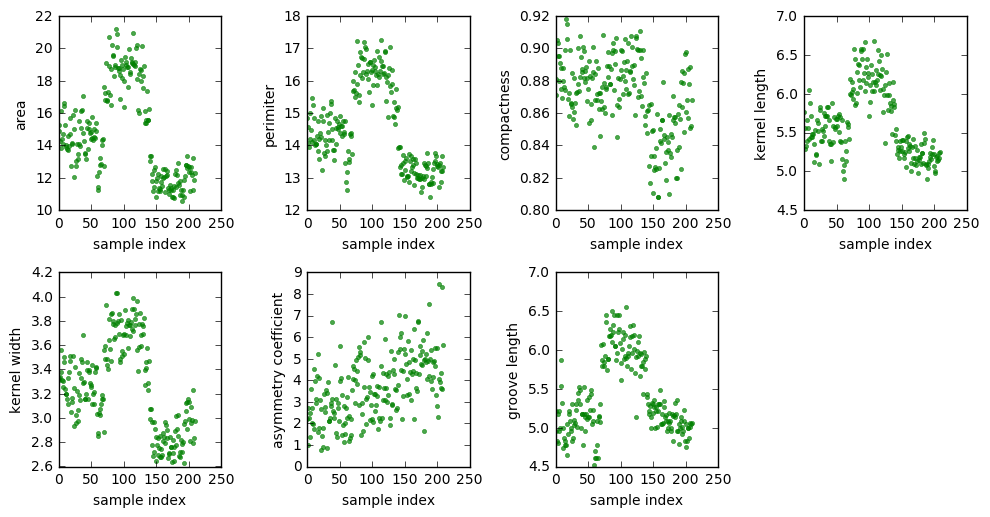

In [230]:
plt.figure(figsize=(10,10))
nrow,ncol = data.shape
for c in range(ncol):
    plt.subplot(4,4, c+1)
    plt.plot(data[:,c],'.g',alpha=0.7)
    plt.ylabel(names[c])
    plt.xlabel('sample index')
plt.tight_layout()

Already, we can see some relations between a few of the attributes; the plots for kernel area, perimiter, length, width, and groove length all look very similar to the eye. This could suggest that these variables have strong relationships. 

---
Now we'll try to predict the groove length based on the other indicators. First we'll construct some plots to show each attribute's relationship with groove length in the dataset.

In [231]:
T = data[:,6:7]
X = data[:,0:6]
Xnames = names[0:6]
Tname = names[6]

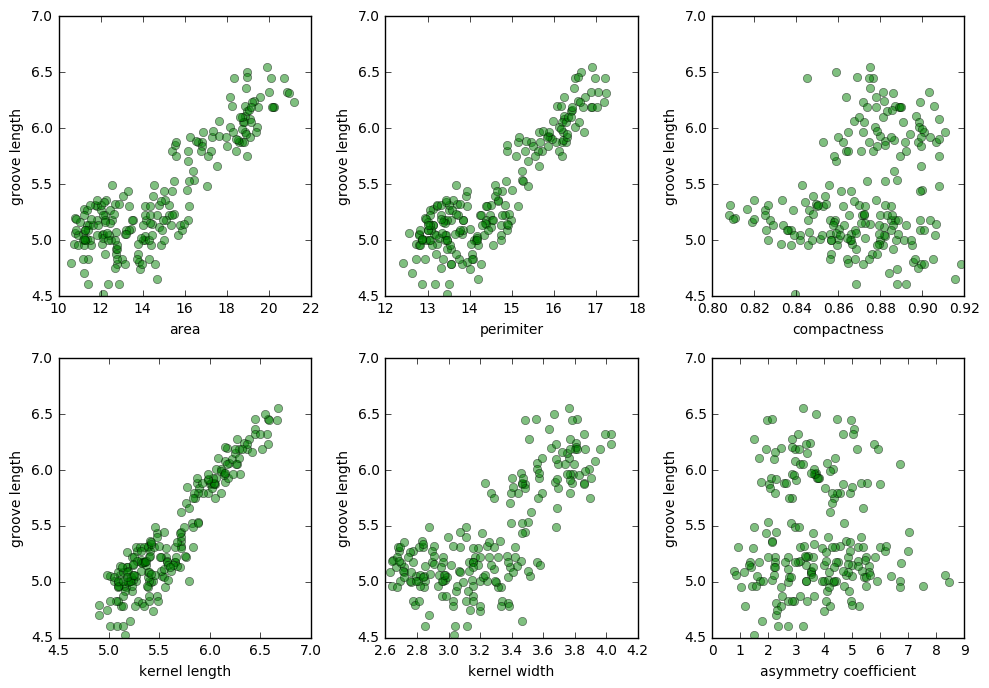

In [232]:
plt.figure(figsize=(10,10))
for c in range(X.shape[1]):
    plt.subplot(3,3, c+1)
    plt.plot(X[:,c], T, 'og', alpha=0.5)
    plt.ylabel(Tname)
    plt.xlabel(Xnames[c])
plt.tight_layout()

These figures present some very striking linear correlations, particularly between groove length and area, perimiter, and kernel length. Intuition would suggest that this finding makes sense as if a seed kernel is longer or bigger, it would follow that the kernel would tend to have longer grooves.

Now we'll partition the data into a test set and a train set. We'll randomly select 80% of the data to go in the train set and put the other 20% in the test set.

In [233]:
Xnames.insert(0, 'bias')

In [234]:
nrows = X.shape[0]
nTrain = int(round(nrow*0.8))
nTest = nrow - nTrain
nTrain,nTest,nTrain+nTest

(168, 42, 210)

So, we ended up with 168 training samples and 42 test samples.

In [235]:
rows = np.arange(nrows)
np.random.shuffle(rows)

In [236]:
trainIndices = rows[:nTrain]
testIndices = rows[nTrain:]

In [237]:
Xtrain = X[trainIndices,:]
Ttrain = T[trainIndices,:]
Xtest = X[testIndices,:]
Ttest = T[testIndices,:]

Now it's time to calculate our weights. We'll use the train function we defined earlier to calculate the weights for our linear model so we can compare how each indicator compares with groove length.

In [238]:
model = train(Xtrain, Ttrain)

[[ 0.36003544  0.25970461  1.30119747 -0.03578327  0.69439204 -1.92909956]
 [ 0.94779945  1.06532614 -0.08121545  1.21681324  0.83660955  0.28090244]
 [-0.35871597 -0.37434938  0.23037603 -0.33308366 -0.34063539 -0.48270936]]


In [239]:
for wi,name in zip(model['w'].flat,Xnames):
    print('{:8.3f}  {:s}'.format(wi,name))

   5.410  bias
   1.544  area
  -0.965  perimiter
  -0.133  compactness
   0.300  kernel length
  -0.344  kernel width
   0.048  asymmetry coefficient


In [240]:
predict = use(model,Xtest)

[[ 1.60842454  1.63385537  0.42159069  1.71530109  1.38129291 -0.53310891]
 [ 0.80509008  0.69443034  1.17262008  0.60806632  1.01319601 -0.61879908]
 [-0.39409035 -0.666419    1.58588492 -1.30345521  0.17661215  0.90621819]]


## Results

In [241]:
predict.shape, Ttest.shape

((42, 1), (42, 1))

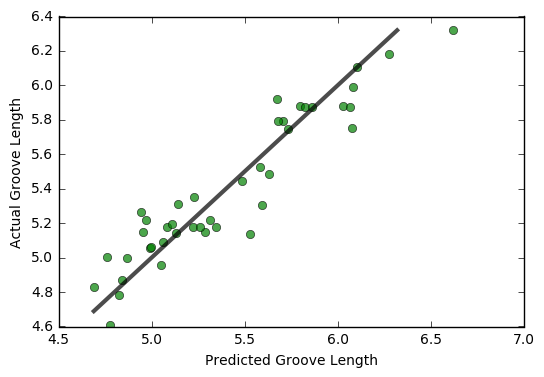

In [242]:
plt.plot(predict,Ttest,'og',alpha=0.7)
plt.xlabel('Predicted Groove Length')
plt.ylabel('Actual Groove Length')
# add a 45 degree line
a = max(min(predict),min(Ttest))
b = min(max(predict),max(Ttest))
plt.plot([a,b],[a,b], 'k', linewidth=3,alpha=0.7);

In [243]:
rmse(predict,Ttest)

0.16217452599153886

So on average, this linear model was about 0.206 cm off from our test values. So how good of a fit is that? To find out, let's look at the sample variance of groove length in the test set.

In [244]:
np.var(Ttest.flat)

0.17560843537414961

So the sample variance of the test set groove length data is about 0.27 cm. So, the linear model's RMS error on the test set was smaller than the test set sample variance. This is good news for the model; it means that the linear model's predictions did not vary more than the actual dataset itself.

Now we'll consider the values of the weights in our model and determine if there are any attributes which could be excluded to find a better model.

In [245]:
sortedOrder = np.argsort(np.abs(model['w'].flat))[::-1]
Xnames = np.array(Xnames)
for wi,name in zip(model['w'].flat[sortedOrder],Xnames[sortedOrder]):
    print('{:8.3f}  {:s}'.format(wi,name))

   5.410  bias
   1.544  area
  -0.965  perimiter
  -0.344  kernel width
   0.300  kernel length
  -0.133  compactness
   0.048  asymmetry coefficient


Show the values of the resulting weights and discuss which ones might be least relevant for fitting your linear model.  Remove them, fit the linear model again, plot the results, and discuss what you see.

## Grading

Your notebook will be run and graded automatically.  Test this grading process by first downloading [A1grader.tar](http://www.cs.colostate.edu/~anderson/cs480/notebooks/A1grader.tar) and extract `A1grader.py` from it. After running all of the above cells in your notebook, run the code in the following cell to demonstrate an example grading session.  You should see a perfect score of 100/100 if your functions are defined correctly.

In [246]:
%run -i "A1grader.py"

[[-0.5        -0.47036043]
 [ 0.         -1.03479296]
 [ 1.5         0.65850461]]
[[-0.5        -0.47036043]
 [ 0.         -1.03479296]
 [ 1.5         0.65850461]]
20/20 points. 'means' values are correct.
20/20 points. 'stds' values are correct.
20/20 points. 'w' values are correct.
20/20 points. Values returned by 'use' are correct.
20/20 points. rmse() is correct.
C:\Users\Derek\cs480\a1 Grade is 100/100


## Check-in

Do not include this section in your notebook.

Name your notebook ```Lastname-A1.ipynb```.  So, for me it would be ```Anderson-A1.ipynb```.  Submit the file using the ```Assignment 1``` link on [Canvas](https://colostate.instructure.com/courses/28803).

Grading will be based on 

  * correct behavior of the three functions listed above,
  * easy to understand plots in your notebook
  * readability of the notebook,
  * effort in making interesting observations, and in formatting your notebook.